# Increasing Batch Size without Increasing Memory

A number of recent papers suggest the benefits of large batch sizes during training, such as [DON'T DECAY THE LEARNING RATE, INCREASE THE BATCH SIZE](https://arxiv.org/pdf/1711.00489.pdf).

But most datasets on modern architectures (i.e. resnet, inception, densnet) are too large to fit into memory.
So what is a researcher on a budget to do?

In this notebook we'll take a look at how to restructure the training loop to effectively multiply the batch size by any positive integer without increasing memory.
The restructured training loop trades compute time for memory, so it isn't a panacea.
However, with the increased batch sizes affording us to use larger learning rates and higher momentum we can still come out ahead.

## The Training Loop

A typical training loop (in pytorch) looks like this:
```python
for inputs, targets in training_data_loader:
    optimizer.zero_grad()
    
    outputs = model(inputs)
    loss = loss_function(outputs, targets)
    loss.backward()
    
optimizer.step()
```

By calling `optimizer.step()` less frequently, we can effectively multiply the batch size like so:
```python
count = 0
for inputs, targets in training_data_loader:
    if count == 0:
        optimizer.step()
        optimizer.zero_grad()
        count = batch_multiplier
    
    outputs = model(inputs)
    loss = loss_function(outputs, targets) / batch_multiplier
    loss.backward()
    
count -= 1
```

## Evidence of Equivalence

How can we check to see that this is in fact equivalent to larget batch sizes for real?
We'll utilize learning rate surveys, showing that the surveys for actually large batch sizes are well matched to these virtually large batches.

In [1]:
from matplotlib import pyplot as plt
from sconce.data_generator import DataGenerator
from sconce.models import MultilayerPerceptron
from sconce.trainers import ClassifierTrainer
from torch import optim
from torchvision import datasets

import sconce
import torch

print(f'Sconce Version: {sconce.__version__}')

def get_trainer(dataset_class=datasets.MNIST, batch_size=100):
    model = MultilayerPerceptron.new_from_yaml_filename('multilayer_perceptron_MNIST.yaml')

    training_generator = DataGenerator.from_pytorch(batch_size=batch_size,
                                                    dataset_class=dataset_class)
    test_generator = DataGenerator.from_pytorch(batch_size=batch_size,
                                                dataset_class=dataset_class,
                                                train=False)

    if torch.cuda.is_available():
        model.cuda()
        training_generator.cuda()
        test_generator.cuda()

    optimizer = optim.SGD(model.parameters(), lr=1e-2,
            momentum=0.9, weight_decay=1e-4)

    trainer = ClassifierTrainer(model=model, optimizer=optimizer,
        training_data_generator=training_generator,
        test_data_generator=test_generator)
    return trainer

trainer = get_trainer()

Sconce Version: 0.5.2


268/300 [=========================>....] - ETA: 14s - loss: 1.4572

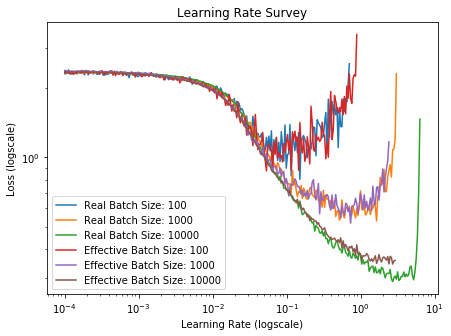

In [2]:
fig = plt.figure(figsize=(7, 5))
ax = fig.add_subplot(1, 1, 1)

# real large batches
for bs in [100, 1_000, 10_000]:
    trainer = get_trainer(batch_size=bs)

    num_epochs = bs / 200
    survey_monitor = trainer.survey_learning_rate(
        num_epochs=num_epochs, min_learning_rate=1e-4, max_learning_rate=10, stop_factor=3)
    survey_monitor.dataframe_monitor.plot_learning_rate_survey(ax=ax, label=f'Real Batch Size: {bs}')

# virtual large batches
for bm in [1, 10, 100]:
    bs = 100
    trainer = get_trainer(batch_size=bs)

    ebs = bs * bm
    num_epochs = ebs / 200
    survey_monitor = trainer.survey_learning_rate(
        num_epochs=num_epochs, min_learning_rate=1e-4, max_learning_rate=10, stop_factor=3, batch_multiplier=bm)
    survey_monitor.dataframe_monitor.plot_learning_rate_survey(ax=ax, label=f'Effective Batch Size: {ebs}')
ax.legend();